In [ ]:
#hide
from nbdev.showdoc import *

# Preprocess hand dataset
> exploring dataset and preprocessing it as needed for this project

### take a look at the dataset as is (in `.mat` format)

In [ ]:
import os, scipy.io, cv2
import matplotlib.pyplot as plt

def mat(path, grid=3, skip=None, figsize=(12, 12)):
    f, axes = plt.subplots(grid, grid, figsize=figsize)
    files = [os.path.join(path, x) for x in os.listdir(path) if x.endswith('.mat')]
    files = files[::skip] if skip else files

    for i, file in enumerate(files[:grid*grid]):
        data = scipy.io.loadmat(file, squeeze_me=True, simplify_cells=True)
        boxes = data['boxes']
        img = cv2.imread(file.replace('annotations', 'images').replace('.mat', '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if not isinstance(boxes, list):
            boxes = [boxes]
        for box in boxes:
            try:
                keys = list('abcd')
                values = [box[x].astype(int) for x in keys]
                allX = [x[1] for x in values]; allY = [x[0] for x in values]
            except Exception as e:
                continue

            topleft = (min(allX), max(allY))
            bottomright = (max(allX), min(allY))
            cv2.rectangle(img, topleft, bottomright, (255, 0, 0), thickness=2)
        axes[i//grid, i%grid].imshow(img)
        axes[i//grid, i%grid].axis('off')
    plt.tight_layout()

change `skip` to skip every `n` files and plot the rest of the files in a square `grid`

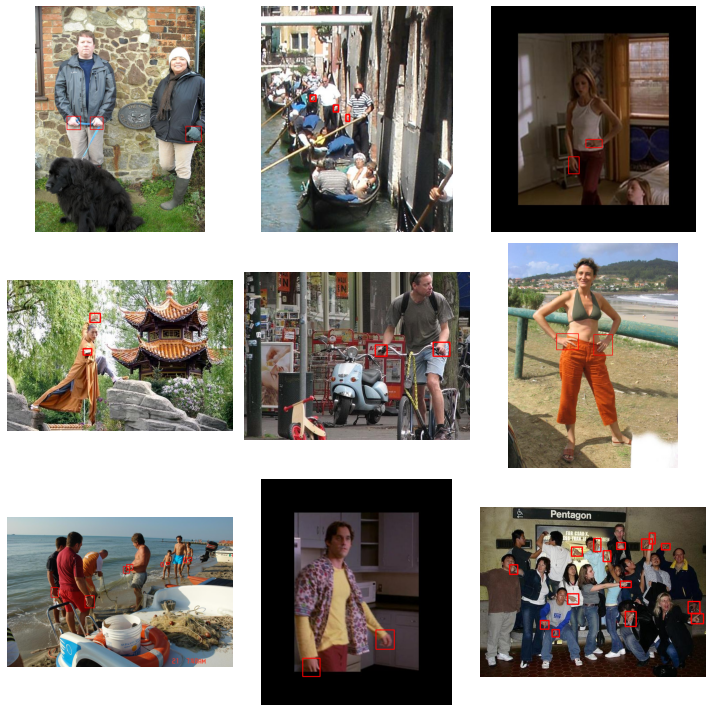

In [ ]:
train_path = '/home/nic/data/hand_dataset/training_dataset/training_data/annotations'
mat(train_path, grid=3, figsize=(10, 10), skip=10)

### convert dataset to yolo format for hand detection pipeline (from `.mat` to `.txt`)

In [ ]:
import tqdm

def convert(path):
    os.makedirs(path.replace('annotations', 'yolo'), exist_ok=True)
    files = [os.path.join(path, x) for x in os.listdir(path) if x.endswith('.mat')]

    for i, file in tqdm.tqdm(enumerate(files)):
        data = scipy.io.loadmat(file, squeeze_me=True, simplify_cells=True)
        boxes = data['boxes']

        imgPath = file.replace('annotations', 'images').replace('.mat', '.jpg')
        yoloPath = imgPath.replace('images', 'yolo')
        txtPath = yoloPath.replace('.jpg', '.txt')
        os.system(f'touch {txtPath}')
        os.system(f'cp {imgPath} {yoloPath}')
        
        img = cv2.imread(imgPath)
        height, width, _ = img.shape
        if not isinstance(boxes, list):
            boxes = [boxes]
        for box in boxes:
            try:
                keys = list('abcd')
                values = [box[x].astype(int) for x in keys]
                allX = [x[1] for x in values]; allY = [x[0] for x in values]
            except Exception as e:
                continue

            topleft = (min(allX), max(allY))
            bottomright = (max(allX), min(allY))
            x = (bottomright[0] + topleft[0]) / 2 / width
            y = (topleft[1] + bottomright[1]) / 2 / height
            w = (bottomright[0] - topleft[0]) / width
            h = (topleft[1] - bottomright[1]) / height
            
            os.system(f'echo \'0 {x} {y} {w} {h}\' >> {txtPath}')

In [ ]:
convert(train_path)

4069it [01:09, 58.44it/s]


### verify correct conversion by visualizing dataset from `.txt` files)

In [ ]:
def yolo(path, grid=3, skip=None, figsize=(12, 12)):
    f, axes = plt.subplots(grid, grid, figsize=figsize)
    files = [os.path.join(path, x) for x in os.listdir(path) if x.endswith('.jpg')]
    files = files[::skip] if skip else files

    for i, file in enumerate(files[:grid*grid]):
        with open(file.replace('.jpg', '.txt'), 'r') as f:
            boxes = [x.split(' ') for x in f.readlines()]
        img = cv2.imread(file.replace('.txt', '.jpg'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape
        if not isinstance(boxes, list):
            boxes = [boxes]
        for box in boxes:
            try:
                _, x, y, w, h = [float(x) for x in box]
                x *= width; w *= width
                y *= height; h *= height

            except Exception as e:
                print('Unknown yolo error: %s %s' % (e, file))
                continue

            topleft = (int(x - w / 2), int(y + h / 2))
            bottomright = (int(x + w / 2), int(y - h / 2))
            cv2.rectangle(img, topleft, bottomright, (255, 0, 0), thickness=2)
        axes[i//grid, i%grid].imshow(img)
        axes[i//grid, i%grid].axis('off')
    plt.tight_layout()

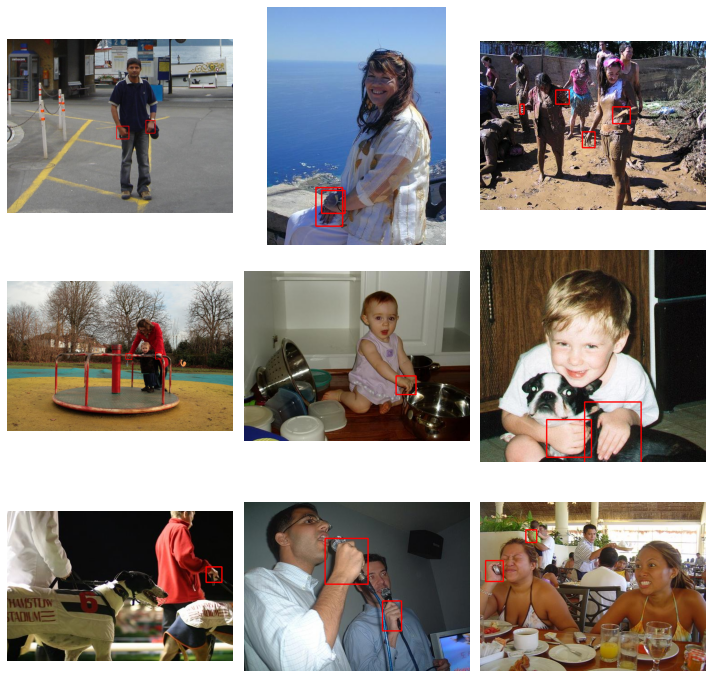

In [ ]:
yolo(train_path.replace('annotations', 'yolo'), grid=3, figsize=(10, 10), skip=10)

### repeat with `test` dataset

821it [00:08, 98.06it/s] 


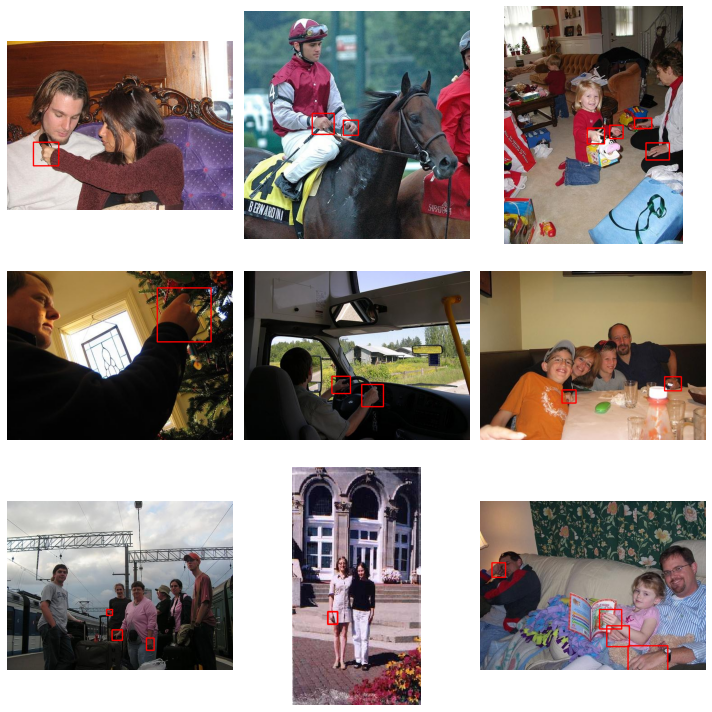

In [ ]:
test_path = '/home/nic/data/hand_dataset/test_dataset/test_data/annotations'
mat(test_path, grid=3, figsize=(10, 10), skip=10)
convert(test_path)

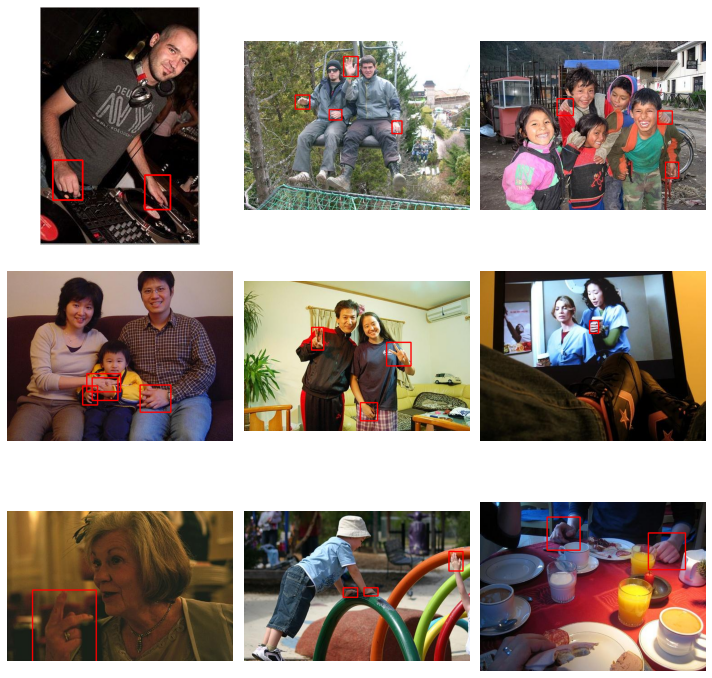

In [ ]:
yolo(test_path.replace('annotations', 'yolo'), grid=3, figsize=(10, 10), skip=10)